## Machine Learning for Signal Processing 2019/2020 
### Teacher: Danilo Comminiello<br>Exam Project

* **Project title**: Human Activity Recognition using Long Short Term Memory Network.
* **Student(s)**: Emanuele Giacomini 1743995.
* **Reference paper / topic**: Hochreiter & Schmidhuber, Long short-term memory. Neural computation, 1997
* **Starting and delivery dates**: 20 July /

## Part 1: Report

In healthcare and, more specifically, eldercare, the ability to perceive the current user's activity may become essential in assistive tasks. 
By continually tracking the patient's activity, it may be possible to immediately react to critical situations that otherwise could lead to potentially unrecoverable injuries.
The recent growth of Machine Learning led to many approaches to consistently solve the Human Activity Recognition (HAR) problem. In this notebook, one possible solution for  HAR is presented, based on Recurrent Neural Networks and more precisely by adopting an LSTM (Long Short Term Memory) Network.

<img src="./images/LSTM.png" />

LSTM, proposed by S. Hochreiter and J. Schmidhuber, is a possible solution to address short-term and long-term information preservation.
An LSTM cell can be seen as an extension of an RU (Recurrent Unit), embedding the recurrent hidden state element for processing short-term information and a memory cell used for long-term storage. Furthermore, the cell contains the set of gates required to control the memory cell:

* Forget Gate
* Input Gate
* Output Gate

The Forget Gate either retains or forgets pieces of information previously stored in the memory cell.
The Input Gate is responsible for deciding which section of the memory cell to update. The Input Gate pairs with an integrated Recurrent Unit, 
which generates potential candidates to store in the memory cell.
Finally, once the memory cell is appropriately updated, the Output Gate decides which portion it should output.


+ Example of an equation inside a notebook:
\begin{equation}
S(\omega)=1.466\, H_s^2 \frac{\omega_0^5}{\omega^6} \exp\Bigl[-3^{\frac{\omega}{\omega_0}}\Bigr]^2
\end{equation}
+ Example of a simple code listing (Python):
```python
import tensorflow as tf
```

**Important**: remember that you can use any [markdown](https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Working%20With%20Markdown%20Cells.html) you want in the report, including headings, links, images, code, and equations.

Please do not use [nbextensions](https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/nbextensions.html) unless *truly* necessary.

**DO**:
+ Have clear and concise explanations.
+ Be mindful of the notation.
+ Proof-read your English.
+ Try to split in coherent sections.

**DON'T**:
+ *Absolutely* no plagiarism from external sources.


## Part 2: External libraries

*List and import here all libraries, code snippets, or GitHub repositories that you have used in your experiments. For non-trivial imports (e.g., excluding Matplotlib), specify in a comment the need for the library. You can also use external commands such as `!git clone`, `!pip install` or `!wget` to set-up the environment and install all pre-requisites.*

**DO**:
+ Be precise with your imports (no `from python import *`).



In [1]:
# Download UCI Human Activity Recognition Dataset (UCI HAR)
!wget -nc https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
!unzip -n UCI\ HAR\ Dataset.zip

# Import external required libraries
import tensorflow as tf
tf.keras.backend.set_floatx('float64')
# Decomment the following two rows if tf-gpu is begin used
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
# Set random seed to determine the networks behaviour
tf.random.set_seed(42)
import numpy as np
from matplotlib import pyplot as plt
# Confusion matrix related imports
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

File ‘UCI HAR Dataset.zip’ already there; not retrieving.

Archive:  UCI HAR Dataset.zip


## Part 3: Your code

*Insert here all the code that you have developed. Try to break it down in meaningful functions, and comment them. For especially complex / long functions, you can put them in an external .py file and import them here.*

**DON'T**:
+ No mindless copy-pasting here.

First we should inspect the dataset in order to understand its composition.

From the `activity_labels.txt` it is possible to see the 6 possible labels for the given samples, namely:
1. WALKING
2. WALKING_UPSTAIRS
3. WALKING_DOWNSTAIRS
4. SITTING
5. STANDING
6. LAYING

For this recognition task, I wanted to use the Inertial Measurement Unit (IMU) raw data composed by 9 parameters:
* Body Accelerometer-XYZ (with gravity compensation) [3]
* Body Accelerometer-XYZ (without gravity compensation) [3]
* Body Gyroscope-XYZ [3]

Subsequently, the dataset is already partitioned into training and test sets (around $0.713$ training/test split with $7352$ samples in the test set)

First I will write the set of basic functions required to read the dataset

In [2]:
DATASET_ROOT_FS = './UCI HAR Dataset/'
TRAINING_FS     = 'train/'
TEST_FS         = 'test/'
INERTIAL_FS     = 'Inertial Signals/'

DATA_FILES = [
    'body_acc_x', 'body_acc_y', 'body_acc_z',
    'body_gyro_x', 'body_gyro_y', 'body_gyro_z',
    'total_acc_x', 'total_acc_y', 'total_acc_z'
]

NUM_CLASSES = 6

In [3]:
def read_data_lst(path: str, max_length=128) -> [np.array]:
    """
    Returns a list of np.arrays. Each element represent a time series for
    measurements indentified by the file 'path'
    """
    data = []
    with open(path, 'r') as f:
        for line in f.readlines():
            line_data = []
            for elem in line.strip().split():
                val = float(elem)
                line_data.append(val)
            data.append(np.array(line_data[:max_length]))
    return np.array(data)

def merge_data(data: [np.array]) -> np.array:
    """
    Merge the lists of features into a single higher-dimensional numpy array.
    Each element of the resulting array contains a vector of features
    """
    return np.transpose(data, (1, 2, 0))

def read_labels_lst(path: str, zero_idx=True) -> [int]:
    """
    Returns the list of labels for a given file identified by 'path'
    """
    labels = []
    with open(path, 'r') as f:
        for lab in f.readlines():
            label = np.array(int(lab.strip()))
            if zero_idx:
                label -= 1
            labels.append(label)
    labels = np.array(labels)
    return np.reshape(labels, (labels.shape[0], 1))

def load_ucihar(train=True, onehot=True):
    main_fs = DATASET_ROOT_FS
    main_fs += TRAINING_FS if train else TEST_FS
    extension = '_train.txt' if train else '_test.txt'
    # Load data
    data_lst = [read_data_lst(main_fs + INERTIAL_FS + dname + extension)
                for dname in DATA_FILES]
    labels_fs = main_fs 
    labels_fs += 'y_train.txt' if train else 'y_test.txt'
    labels = read_labels_lst(labels_fs, True)
    data = merge_data(data_lst)
    if onehot:
        labels = tf.keras.utils.to_categorical(labels, NUM_CLASSES)
    return data, labels

LABELS = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']

def onehot2label(onehot: np.array) -> str:
    return LABELS[np.argmax(onehot)]

In [4]:
uci_x_train, uci_y_train = load_ucihar(train=True, onehot=True)
uci_x_test, uci_y_test   = load_ucihar(train=False, onehot=True)

In [5]:
print(uci_x_train.shape, uci_y_train.shape)
print(uci_x_test.shape, uci_y_test.shape)

(7352, 128, 9) (7352, 6)
(2947, 128, 9) (2947, 6)


We can plot some examples from the training set in order to see which kind of data samples we're treating. In this case I will print only $3$ of the $9$ features per data sample which represent the __body acceleration in XYZ directions__. Just from these samples its possible to clearly see some differences between the data samples differently labelled

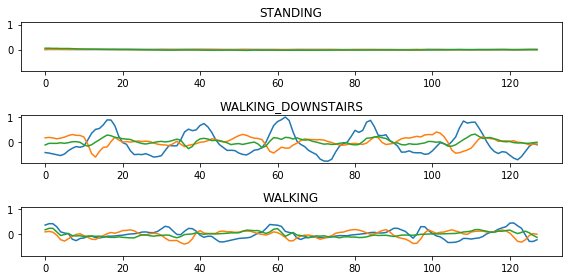

In [6]:
def plot_samples(data_lst:[[np.array]], labels:[str]) -> None:
    fig, axs = plt.subplots(len(data_lst), figsize=(8, 4), sharey=True)
    for i in range(len(data_lst)):
        # Plot-wise loop
        for j in range(len(data_lst[i])):
            axs[i].plot(data_lst[i][j])
        axs[i].set_title(labels[i])
    plt.tight_layout()
        
    
plot_samples([[uci_x_train[0][:,0], uci_x_train[0][:,1], uci_x_train[0][:,2]],
             [uci_x_train[4500][:,0], uci_x_train[4500][:,1], uci_x_train[4500][:,2]],
             [uci_x_train[2000][:,0], uci_x_train[2000][:,1], uci_x_train[2000][:,2]]],
            [onehot2label(uci_y_train[0]), onehot2label(uci_y_train[4500]), onehot2label(uci_y_train[2000])])
    

Finally, Im going to transform the obtained data into a tf.Dataset in order to ease the manipulability of it later

In [7]:
BUFFER_SIZE = 5000
BATCH_SIZE = 128
NUM_FEATURES = 9

har_train = tf.data.Dataset.from_tensor_slices((uci_x_train, uci_y_train))
har_train = har_train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

har_val = tf.data.Dataset.from_tensor_slices((uci_x_test, uci_y_test))
har_val = har_val.cache().batch(BATCH_SIZE)

## Keras Model
Not having a clear idea on how to compose my network, I've decided to experiment different models

In [8]:
lstm_estimator_01 = tf.keras.models.Sequential()
lstm_estimator_02 = tf.keras.models.Sequential()
lstm_estimator_03 = tf.keras.models.Sequential()

lstm_estimator_01.add(tf.keras.layers.LSTM(128))
lstm_estimator_01.add(tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'))
lstm_estimator_01.compile(optimizer='adam',
                         loss=tf.keras.losses.CategoricalCrossentropy(),
                          metrics=['acc'])

lstm_estimator_02.add(tf.keras.layers.LSTM(512))
lstm_estimator_02.add(tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'))
lstm_estimator_02.compile(optimizer='adam',
                         loss=tf.keras.losses.CategoricalCrossentropy(),
                          metrics=['acc'])

lstm_estimator_03.add(tf.keras.layers.LSTM(256))
lstm_estimator_03.add(tf.keras.layers.Dense(64, activation='relu'))
lstm_estimator_03.add(tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'))
lstm_estimator_03.compile(optimizer='adam',
                         loss=tf.keras.losses.CategoricalCrossentropy(),
                          metrics=['acc'])

models = [lstm_estimator_01, lstm_estimator_02, lstm_estimator_03]

## Part 4 - Experimental evaluation

*Almost done! Now you just need to convince me your code is working correctly.*

**DO**:
+ Provide a brief explanation of every experiment.
+ All plots must *always* have self-explicative labels and captions.
+ For long training times (e.g., > 1h), provide a comment and possibly a simplified set-up and/or a pre-trained model.

**DON'T**:
+ Assume by default I know what you are doing.

In order to prevent overfitting of the models, I have applied the __Early Stopping__ callback provided by the _Keras API_ which keeps track of a specified metric and stops the training if a minimum is found. In this case I will keep track of the __validation loss__ which is not directly affected by the training

In [9]:
NUM_EPOCHS = 100
models_history = []
for i, model in enumerate(models):
    print(f'Starting training phase for model no. {i}...', end='')
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=7, restore_best_weights=True)
    hist = model.fit(har_train,
                     epochs=NUM_EPOCHS,
                     validation_data=har_val,
                     callbacks=[early_stopping_cb],
                     verbose=True)
    print('Completed.')
    models_history.append(hist)

Starting training phase for model no. 0...Epoch 1/100
58/58 [==============================] - 6s 109ms/step - loss: 1.2828 - acc: 0.4563 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 2/100
58/58 [==============================] - 4s 66ms/step - loss: 0.8772 - acc: 0.6311 - val_loss: 0.8530 - val_acc: 0.6712
Epoch 3/100
58/58 [==============================] - 4s 67ms/step - loss: 0.6873 - acc: 0.7189 - val_loss: 0.7102 - val_acc: 0.7302
Epoch 4/100
58/58 [==============================] - 4s 67ms/step - loss: 0.5362 - acc: 0.7961 - val_loss: 0.6132 - val_acc: 0.7591
Epoch 5/100
58/58 [==============================] - 4s 67ms/step - loss: 0.4306 - acc: 0.8478 - val_loss: 0.4969 - val_acc: 0.8208
Epoch 6/100
58/58 [==============================] - 4s 68ms/step - loss: 0.3246 - acc: 0.8876 - val_loss: 0.3876 - val_acc: 0.8683
Epoch 7/100
58/58 [==============================] - 4s 68ms/step - loss: 0.2464 - acc: 0.9113 - val_loss: 0.4304 - val_acc: 0.8466
Epoch 8/100
58/58 [======

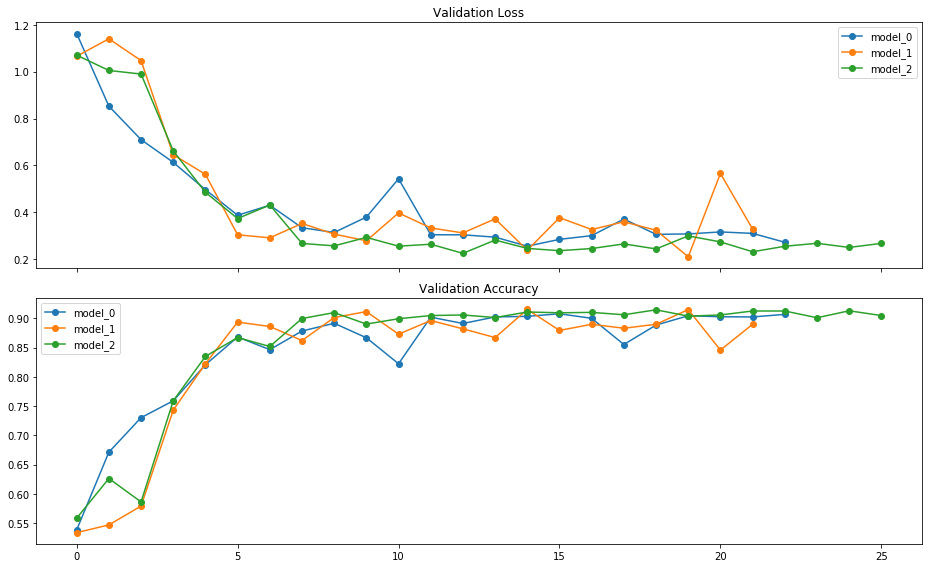

In [10]:
def plot_models_result(history: [tf.keras.callbacks.History]) -> None:
    fig, axs = plt.subplots(2, figsize=(13, 8), sharex=True)
    for i, hist in enumerate(history):
        axs[0].plot(hist.history['val_loss'], '-o', label=f'model_{i}')
        axs[1].plot(hist.history['val_acc'], '-o', label=f'model_{i}')
    axs[0].legend()
    axs[1].legend()
    axs[0].set_title('Validation Loss')
    axs[1].set_title('Validation Accuracy')
    plt.tight_layout()
    
plot_models_result(models_history)

As we can see, both model_0 and model_2 performs really well, where the latter has better performance by obtaining $91.2\%$ accuracy in the validation test.

We will now visualize the confusion matrix for model_2:

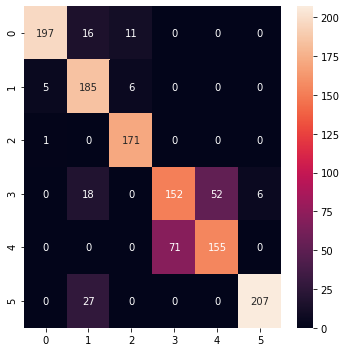

In [11]:
def plot_confusion_matrix(confusion_mat: np.array) -> None:
    fig, ax = plt.subplots(figsize=(5,5))
    df_cm = pd.DataFrame(confusion_mat.astype(np.int), range(NUM_CLASSES), range(NUM_CLASSES))
    ax = sn.heatmap(df_cm, annot=True, fmt='d')
    ax.set_ylim(len(confusion_mat), 0.0)
    

cm = np.zeros(shape=(NUM_CLASSES, NUM_CLASSES))
for x_val, y_val in har_val.take(10):
    y_true = np.argmax(y_val, axis=1)
    y_pred = np.argmax(models[2].predict(x_val), axis=1)
    tcm = confusion_matrix(y_true, y_pred, labels=range(0, NUM_CLASSES))
    cm += tcm

plot_confusion_matrix(cm)
plt.tight_layout()
plt.show()


Overall the network performs quite well in discriminating the different classes, however a misclassification problem can be noticed between the labels 3 and 4. Around half of the __SITTING__ samples are misclassified as __STANDING__ and viceversa.

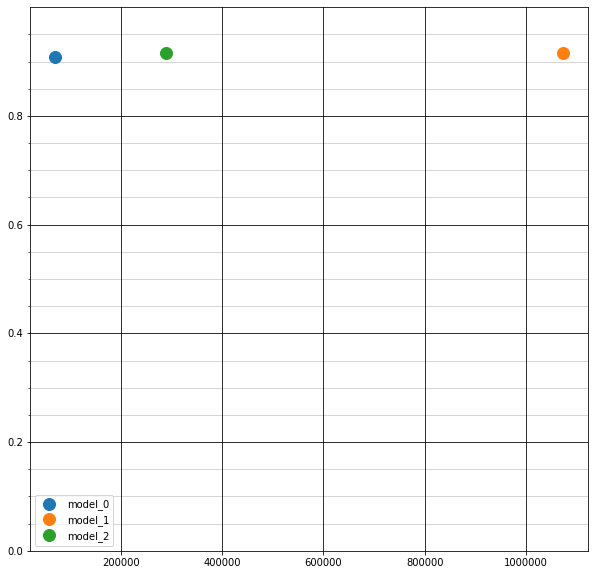

In [12]:
def count_params(model:tf.keras.models.Model) -> int:
    trainable_count = int(np.sum([tf.keras.backend.count_params(p) for p in list(model.trainable_weights)]))
    return trainable_count

fig, ax = plt.subplots(figsize=(10,10))
model_params = [count_params(m) for m in models]
max_accuracy = [np.max(h.history['val_acc']) for h in models_history]
#ax.plot(np.array(model_params), np.array(max_accuracy), 'x')
for i in range(len(model_params)):
    ax.plot(model_params[i], max_accuracy[i], 'o', label=f'model_{i}', markersize=12)
ax.set_yticks(np.arange(0, 1, 0.2))
ax.set_yticks(np.arange(0, 1, 0.05), minor=True)
ax.set_facecolor('None')
ax.grid(True, which='both', color='black')
ax.grid(which='minor', alpha=0.2)
ax.legend()
ax.set_ylim(0, 1)
plt.show()

Despite begin quite similar in terms of accuracy, model_0 provides over $90\%$ of accuracy having less than half trainable parameters with respect to model_2

In [13]:
pd.DataFrame(np.array(max_accuracy) / np.array(model_params), columns=['acc_params ratio'])

,acc_params ratio
0,1.271233e-05
1,8.539113e-07
2,3.163067e-06
